In [16]:
import json
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Copy and paste source below between the triple quotes

In [32]:
source = r"""



"""

# Additional sources for grade comparison

source2 = r"""

"""
source3 = r"""

"""

In [49]:
def read_source(source):
    """
    Reads page source from printed grade page.
    """
    match = re.findall("progressGrades = ([^;]+)", source)
    if match:
        return json.loads(match[0])
    
class Course(object):
    """
    Hold information about single course taken from file for further analysis
    """
    def __init__(self, code, name, grade, ects, date, passed):
        self.code = code
        self.name = name
        self.grade = grade
        self.ects = int(ects)
        self.date = date
        self.passed = passed



class Student(object):
    """
    Reads data from JSON file and creates instances of Course objects to hold relevant data

    Methods:
    rolling_average(time_list) : average grade so far returned in list
    plot_grades : plots series of grades and some trend lines
    plot_dist : plots distribution of grades in histogram
    plot_subjects: parses course codes to separate subjects, plots histogram
    """
    def __init__(self, filename):
        data = read_source(filename)
        self.name = filename
        # Parse the JSON into Course objects for use in the program
        self.courses = [
            Course(g['course']['code'], g['course']['nameEn'], g['results'][0]['grade'], g['results'][0]['ects'],
                   g['results'][0]['examDate'], g['results'][0]['isPassed']) for g in data['grades']]
        self.sub_dict = self.sort_subjects()
        self.av_dict = self.course_averages()

    def rolling_average(self, time_list):
        """
        Returns a list of the average grade at any time point, used for plotting the rolling average on the graph
        """
        averages = []
        for i in range(len(time_list)):
            averages.append(sum(time_list[:i + 1]) / (i + 1))

        return averages

    def generate_data(self, courses):
        """
        Returns the x and y values (grade, date) to be plotted in a time series. Accepts list of course objects
        """
        x, y = [], []
        for course in courses:
            try:
                if course.passed:
                    for _ in range(course.ects):
                        y.append(float(course.grade))
                        x.append(dt.datetime.strptime(course.date, '%Y-%m-%d').date())
            except:
                pass

        return x, y

    def plot_grades(self, points=True, average=True, threemonth=True):
        """
        Plots basic time series without course code classification
        """
        x, y = self.generate_data(self.courses)

        # This code can be used to plot linear fit to all grades. Uncomment Straight fit and below code to use.
        # xx = mdates.date2num(x)
        # m, a = np.polyfit(xx, y, 1)
        # linx = np.linspace(min(xx), max(xx), len(xx))

        # convert to date time using pandas and then sort data in frame by time (needed for rolling average)
        datetime = pd.to_datetime(x)
        series = pd.Series(y, index=datetime)
        series.sort_index(inplace=True)

        # resample data to give 3 month average line
        monthly = series.resample('3M').mean()
        rollingaverage = self.rolling_average(series.values)

        # print name and overall grade average
        print(np.mean(y))

        # begin figure and set parameters
        if average:
            plt.plot(series.index.values, rollingaverage, label='%s Average' % self.name)
        `# plt.plot(x, xx * m + a, label='Straight Fit: %2.6f' % m)
        if threemonth:
            plt.plot(monthly, label='%s: 3 Month Average' % self.name[0], alpha=0.2)
        if points:
            plt.scatter(x, y, s=100, alpha=0.2, label='%s: Course of %s' % (self.name[0], self.name))
        
        plt.show()

    def plot_dist(self):
        """"
        Basic histogram plt to show grade distribution
        """
        grades = []
        for course in self.courses:
            try:
                if course.passed:
                    for _ in range(course.ects):
                        grades.append(float(course.grade))
            except:
                pass

        plt.hist(grades, np.arange(6, 11, 0.5), align='left', alpha=0.5, label="Grades of %s" % self.name)

    def hist(self, grade_list):
        """
        Generate data for representation in histogram, per ects not course
        """
        grades = []
        for course in grade_list:
            try:
                if course.passed:
                    for _ in range(course.ects):
                        grades.append(float(course.grade))
            except:
                pass

        return grades

    def pie(self):
        sizes, labels, ects = [], [], []
        total, tot_credits = 0, 0
        for name, subject in self.sub_dict.items():
            if len(subject):
                credits = 0
                for course in subject:
                    credits += course.ects

                tot_credits += credits
                ects.append(credits)
                sizes.append(len(subject))
                labels.append(name + '\n' + str(credits) + "ECTS")
                total += len(subject)

        sizes = [entry/total for entry in sizes]

        ects = [entry/tot_credits for entry in ects]

        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(122)
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Total Courses: " + str(total))
        #plt.show()

        #fig1, ax1 = plt.subplots()
        ax2 = fig.add_subplot(121)
        ax2.pie(ects, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Total Credits: " + str(tot_credits))
        plt.show()

    def sort_subjects(self):
        physics = []
        maths = []
        honours = []
        astronomy = []
        computing = []
        other = []
        sub_dict = {'Physics': physics, 'Maths': maths, 'Honours': honours, 'Astronomy': astronomy,
                    'Computing': computing, 'Other': other}

        for course in self.courses:
            two_letters = course.code[:2]
            if two_letters == 'HC':
                honours.append(course)
            elif two_letters == 'WI' or course.code[:4] == 'WPMA':
                maths.append(course)
            elif two_letters == 'NA' or course.code[:4] == 'WBPH' or course.code[:4] == 'WPPH':
                physics.append(course)
            elif two_letters == 'ST':
                astronomy.append(course)
            elif two_letters == 'RC' or two_letters == 'KI':
                computing.append(course)
            else:
                other.append(course)

        return sub_dict

    def course_averages(self):
        av_dict = {}
        for name, subject in self.sub_dict.items():
            average, courses = 0, 0
            for course in subject:
                if course.passed and course.grade:
                    average += course.grade
                    courses += 1

            if average:
                average /= courses

                av_dict[name] = average

        return av_dict

    def plot_subjects(self):
        """
        Attempt to parse courses depending on what their course code is. May need to be changed for other studies.
        """


        # plot histogram of grade distribution for different subjects
        xhist = []
        labels = []
        for name, subject in self.sub_dict.items():
            subjectx = self.hist(subject)
            xhist.append(subjectx)
            labels.append(name)

        # plotting area and setup
        plt.figure(figsize=(20, 10))
        plt.hist(xhist, np.arange(6, 11, 0.5), align='left', alpha=0.5)
        plt.xticks(np.arange(6, 11, 0.5))
        plt.xlabel('Grade out of 10')
        plt.ylabel('ECTS')
        plt.legend(labels)
        plt.show()

        # plot time series with subject distinctions
        plt.figure(figsize=(20, 10))
        plt.ylim([5, 10])
        plt.grid()
        for name, subject in self.sub_dict.items():
            if len(subject) != 0:
                x, y = self.generate_data(subject)
                plt.scatter(x, y, label=name, alpha=0.2)

        x, y = self.generate_data(self.courses)
        datetime = pd.to_datetime(x)
        series = pd.Series(y, index=datetime)
        series.sort_index(inplace=True)
        # monthly = series.groupby(series.index.map(lambda t: t.month))
        monthly = series.resample('3M').mean()
        rollingaverage = self.rolling_average(series.values)

        plt.plot(series.index.values, rollingaverage, label='Rolling Average', color='r')
        plt.text(series.index.values[-1], rollingaverage[-1], str(round(np.mean(y), 3)), color='r')
        # plt.plot(x, xx * m + a, label='Straight Fit: %2.6f' % m)
        plt.plot(monthly, label='3 Month Average')
        plt.xlabel('Date')
        plt.ylabel('Grade out of 10')
        plt.title('Grade Time Series')
        plt.legend()
        plt.show()

    def subject_averages_bar(self):
        X = np.arange(len(self.av_dict))
        plt.bar(X, self.av_dict.values(), align='center', width=0.5)
        labels = ["%2.2f" % entry for entry in self.av_dict.values()]
        y = [float(entry) for entry in self.av_dict.values()]
        
        plt.xticks(X, self.av_dict.keys())
        plt.ylim(5, 10)
        plt.show()


def compare_grades(student_list):
    plt.figure(figsize=(20, 10))
    plt.ylim([5, 10])
    plt.grid()
    plt.title('Grade Comparison')
    for student in student_list:
        student.plot_grades(points=False, threemonth=False)
    plt.xlabel('Time')
    plt.ylabel('Grade')
    plt.legend()
    plt.show()


SyntaxError: invalid syntax (<ipython-input-49-46011090d032>, line 95)

7.629464285714286


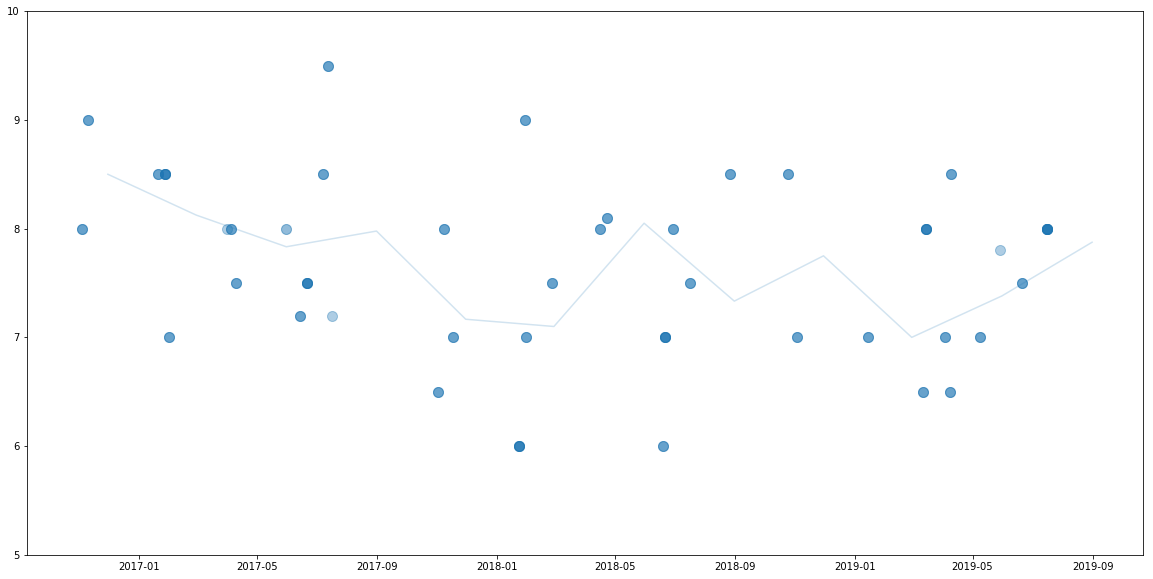

In [53]:
# enter filenames here for comparison between multiple students
student_names = [
    source,
    #source2,
    #source3,
]

# initialise student objects for each person in data list
student_list = [Student(name) for name in student_names]

# plot the average grades of the students over time
if len(student_list) < 1:
    compare_grades(student_list)

# enter filenames to be parsed in list below. Files should be complete source from the printed grades website
filenames = [
    source
]

# uncomment desired plotting functions in loops below.
for filename in filenames:
    student = Student(filename)
    # start figure for plotting
    plt.figure(figsize=(20, 10))
    plt.ylim([5, 10])
    #plt.grid()
    student.plot_grades()
    

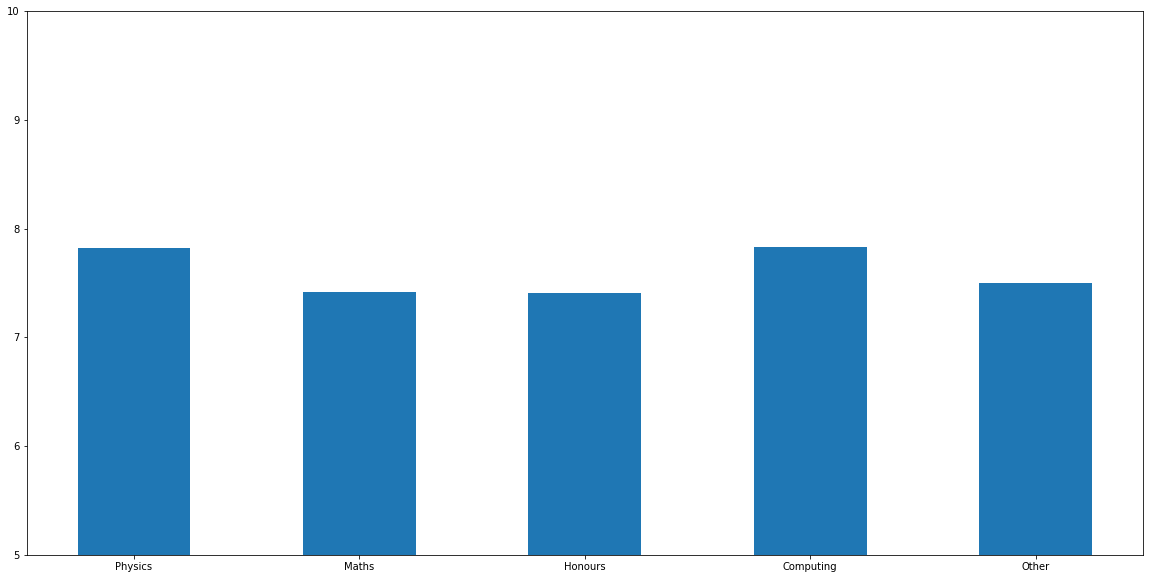

In [54]:
for filename in filenames:
    student = Student(filename)
#plt.legend()
    #plt.show()
    #student.plot_dist()
    #plt.show()
    #student.plot_subjects()
    #student.pie()
    plt.figure(figsize=(20, 10))
    student.subject_averages_bar()

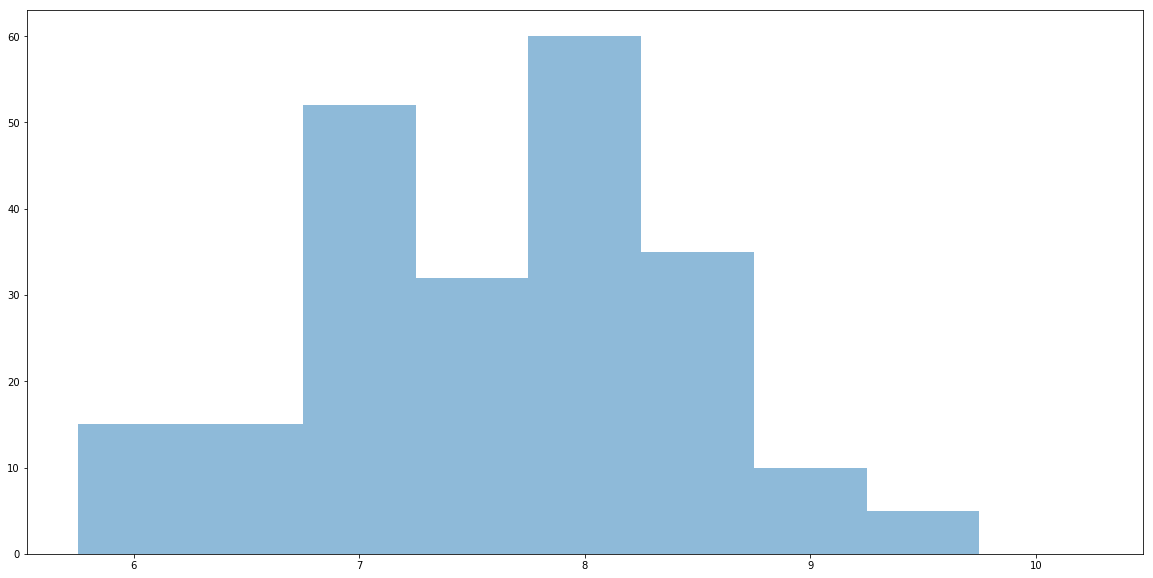

In [56]:
for filename in filenames:
    student = Student(filename)
    plt.figure(figsize=(20,10))
    student.plot_dist()
    plt.show()

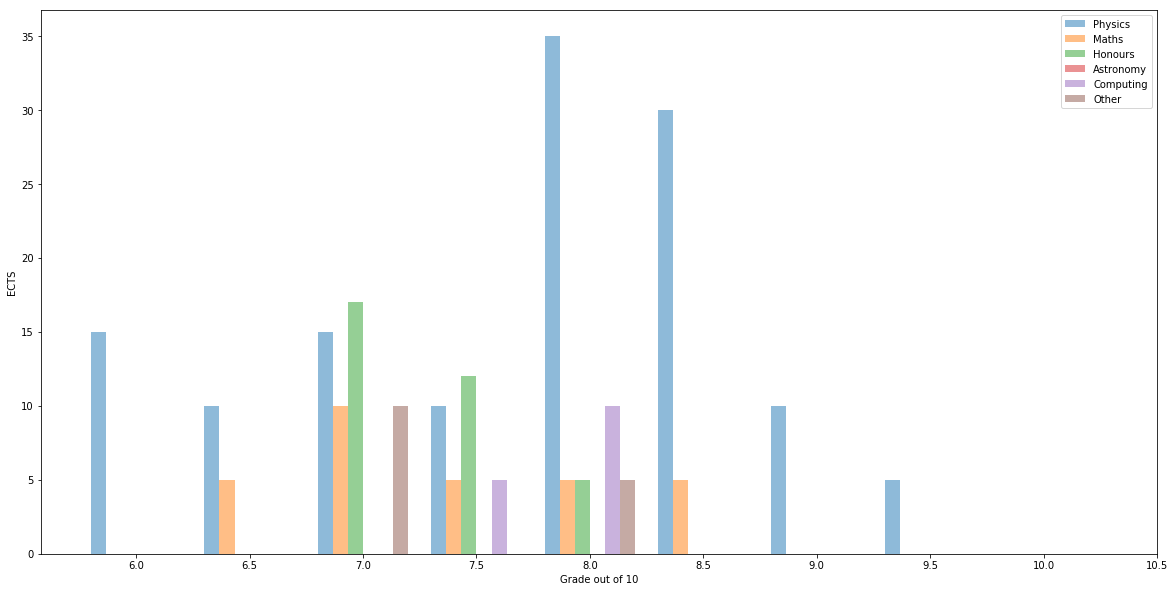

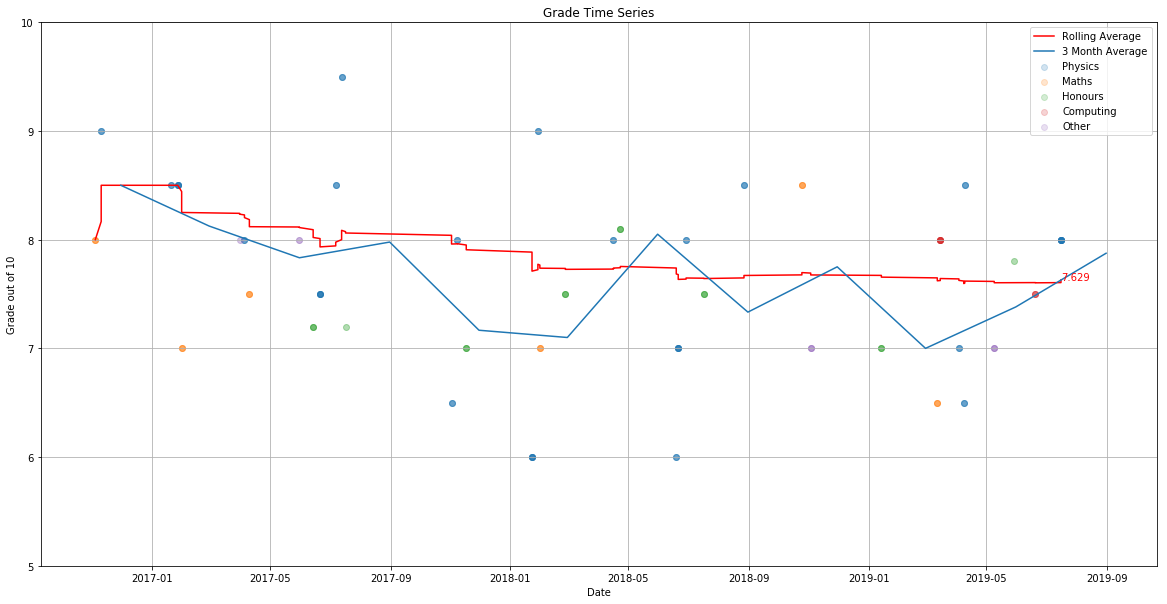

In [57]:
for filename in filenames:
    student = Student(filename)
    student.plot_subjects()
    #student.pie()

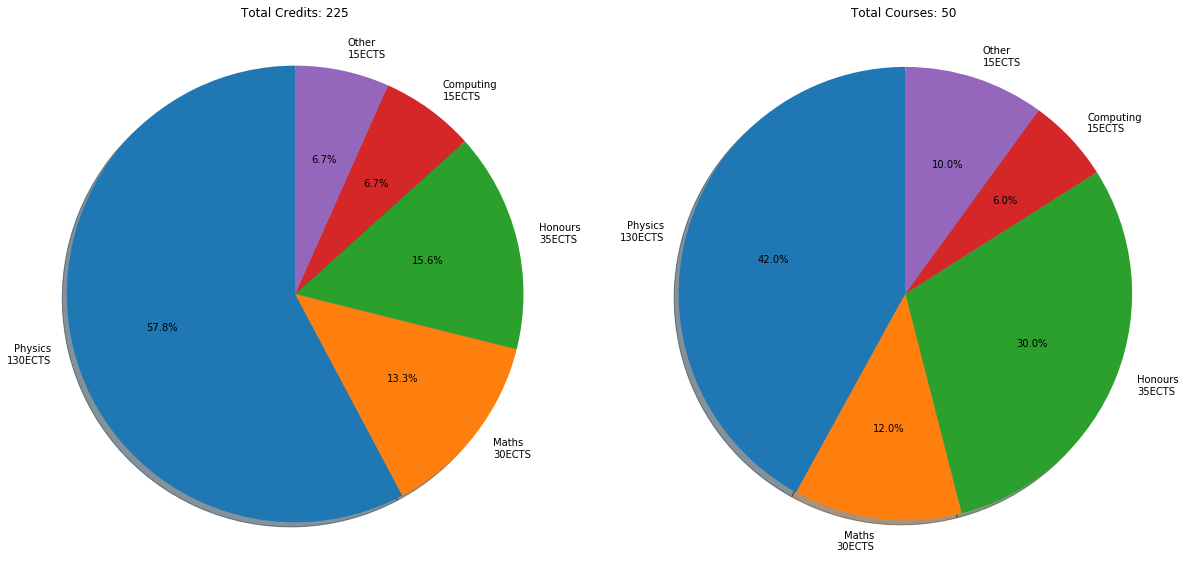

In [58]:
for filename in filenames:
    student.pie()